In [1]:
### 기본
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

### tuning
from sklearn.metrics import *
from sklearn.model_selection import KFold
import warnings

### model 
import lightgbm as lgb

### os
from tqdm import tqdm
import gc
import random
import re

warnings.filterwarnings(action='ignore')

# Visualization
import matplotlib.pylab as plt
from matplotlib import font_manager, rc
import seaborn as sns
%matplotlib inline

# EDA
import klib

# Preprocessing & Feature Engineering
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectPercentile

# Hyperparameter Optimization
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# Modeling
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

# Evaluation
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# Utility
import os
import time
import random
import warnings; warnings.filterwarnings("ignore")
from IPython.display import Image
import pickle
from tqdm import tqdm
import platform
from itertools import combinations
from scipy.stats.mstats import gmean
import time

In [2]:
# 데이터 불러오기
train = pd.read_csv('train_knn_scale.csv')
train_y = pd.read_csv('train_Y_LABEL.csv')
test = pd.read_csv('test_knn_scale.csv')
test_id = pd.read_csv('sample_submission.csv')['ID']

In [3]:
train_x = np.array(train)
train_s = np.array(train.loc[:,test.columns])
test_x = np.array(test)

In [6]:
# 학습데이터 70%, 평가데이터 30%로 데이터 분할
X_train, X_dev, y_train, y_dev = train_test_split(train_s, train_y, test_size=0.3, random_state=0,stratify=train_y)

In [7]:
clfs = [
    (
       CatBoostClassifier(random_state=0, verbose=False),
       {'n_estimators': range(10, 310, 10),
        'depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
        'random_strength': [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],
        'l2_leaf_reg': [1,2,3,4,5,6,7,8,9,10,20,30,50,100,200],
        'boost_from_average' : [False]}
    ),
    (
        LGBMClassifier(random_state=0),
        {'num_iteration': [100, 200, 300],
         'learning_rate': [1, 0.1, 0.01],
         'max_depth':[3,4,6,8,10],
         'min_data_in_leaf':[5,10,50,70,100],
         'num_leaves':[15,31,35],
         'boosting':['gbdt','rf'],
         'n_estimators': range(10, 200, 10),
         'min_split_gain': [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
         #'reg_alpha': [0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,1,2,3,4,5,10],
         'reg_lambda': [0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,1,2,3,4,5,10],
         'feature_fraction': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
         #'bagging_fraction': [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
         'bagging_freq': [1, 2, 3, 4, 5, 6, 7],
         'min_child_samples': range(5,50,5),
         'boost_from_average' : [False]
         }
    ),
    (
        XGBClassifier(random_state=0),
        {'learning_rate': [1, 0.1, 0.01],
         'n_estimators': [100, 200, 300],
         'max_depth':[3,4,6,8,10],
         'subsamle':[0.3, 0.5, 0.7, 1],
         'min_child_weight':[10,20,50,100],
         'objective':['binary:logistic'],
         'eval_metric':['error'],
         'min_split_loss':[10,20,50,100],
         'colsample_bytree': [0.5, 0.7, 0.9, 1],
         'reg_alpha': [0.0001,0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,1,2,3,4,5,10],
         'reg_lambda': [0.0001,0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,1,2,3,4,5,10],
         'scale_pos_weight': np.arange(0.0, 50.1, 0.1)
        }
    )
#    (
#        KNeighborsClassifier(),              # 사용하려는 모델
#        {'n_neighbors': [3,5,7,9,11],        # 최적화하려는 하이퍼파라미터
#         'weights': ['uniform','distance'],
#         'algorithm': ['auto','ball_tree', 'kd_tree', 'brute'],
#         'leaf_size': [10, 20, 30, 40],
#         'p': [1,2],
#         'metric': ['minkowski', 'euclidean', 'manhattan']}
#    ),
#    (
#        MLPClassifier(random_state=0),
#        {'batch_size': ['auto', 32, 64, 128],
#         'learning_rate' : ['constant', 'adaptive','invscaling'],
#         'activation': ['tanh', 'relu'],
#         'solver': ['sgd', 'adam'],
#         'hidden_layer_sizes': [10,30,50,100],
#         'alpha': [1e-07,1e-06,0.0001,0.001,0.01,0.0005,0.005,0.05,0.1,0.15,0.2,0.3,0.4,0.5,0.7,0.9]}
#    ),
#    (
#        LogisticRegression(random_state=0),  
#        {'C': np.arange(0.1, 1.1, 0.1),      
#         'penalty': ['l1','l2'],
#         'max_iter' : [100, 300, 500, 1000],
#         'solver' : ['liblinear']}
#    ),
#    (
#        RandomForestClassifier(random_state=0),
#        {'n_estimators': [100,200,300],
#         'max_depth': [None,3,4,5,6],
#         'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int),
#         'criterion': ['gini','entropy'],
#         'min_samples_split':[2,3,4],
#         'min_samples_leaf':[1,2,4],
#         'min_impurity_decrease': [0,0.0001,0.001,0.01,0.0002,0.002,0.02,0.0005,0.005,0.05,0.1,0.2,0.3,0.4,0.5],
#         'bootstrap': [True, False],
#         'class_weight': ['balanced', 'balanced_subsample', {}]}
#    ),
#    (
#        GradientBoostingClassifier(random_state=0),
#        {'n_estimators': [100, 200, 300],
#         'learning_rate': [1, 0.1, 0.01],
#         'criterion': ['friedman_mse', 'mse', 'mae'],
#         'loss': ['deviance', 'exponential'],
#         'min_samples_split': [2, 4, 5, 7, 9, 10],
#         'min_samples_leaf': [1, 2, 3, 4, 5],
#         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
#         'min_impurity_decrease': [0,0.0001,0.001,0.01,0.0002,0.002,0.02,0.0005,0.005,0.05,0.1,0.2,0.3,0.4,0.5],
#         'max_features': (np.arange(0.5, 1.0, 0.1)*X_train.shape[1]).astype(int)
#        }
#    ),
#    (
#        DecisionTreeClassifier(random_state=0),
#        {'criterion' :['gini','entropy'],
#         'max_depth':[3,4,6,8,10],
#         'min_samples_leaf':[3,5,10,50,100],
#         'splitter':["best","random"]
#        }
#   )
]

clfs_tuned = []  # 튜닝된 모델을 저장
start_time = time.time()
for clf, param_grid in tqdm(clfs):
    start = time.time()
    rand_search = RandomizedSearchCV(clf, param_grid, n_iter=8, scoring='f1_macro', 
                                     cv=3, random_state=0, n_jobs=-1)
    rand_search.fit(X_train, y_train)
    clf_name = type(clf).__name__
    clf_score = rand_search.score(X_dev, y_dev)
    print('{:30s} {:30f} {:.1f}'.format(clf_name, clf_score, time.time() - start))
    print('final params', rand_search.best_params_)
    clfs_tuned.append((clf_name, rand_search, clf_score))
    #globals()['{}_pred'.format(clf_name)] = pd.DataFrame(rand_search.best_estimator_.predict(test_x))
print('모델 수행 시간: {0:.1f} 초'.format(time.time()- start_time))

 33%|███████████████████████████▋                                                       | 1/3 [01:40<03:20, 100.32s/it]

CatBoostClassifier                                   0.504979 100.3
final params {'random_strength': 0.3, 'n_estimators': 270, 'l2_leaf_reg': 2, 'depth': 6, 'boost_from_average': False}
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] num_iterations is set=300, num_iteration=300 will be ignored. Current value: num_iterations=300


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:48<00:46, 46.06s/it]

LGBMClassifier                                       0.541613 8.0
final params {'reg_lambda': 0.05, 'num_leaves': 35, 'num_iteration': 300, 'n_estimators': 30, 'min_split_gain': 0, 'min_data_in_leaf': 70, 'min_child_samples': 25, 'max_depth': 6, 'learning_rate': 1, 'feature_fraction': 0.5, 'boosting': 'gbdt', 'boost_from_average': False, 'bagging_freq': 6}
[02:19:20] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "subsamle" } are not used.



100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [02:03<00:00, 41.17s/it]

XGBClassifier                                        0.548163 15.1
final params {'subsamle': 1, 'scale_pos_weight': 8.6, 'reg_lambda': 1, 'reg_alpha': 0.001, 'objective': 'binary:logistic', 'n_estimators': 200, 'min_split_loss': 100, 'min_child_weight': 50, 'max_depth': 6, 'learning_rate': 0.01, 'eval_metric': 'error', 'colsample_bytree': 0.5}
모델 수행 시간: 123.5 초


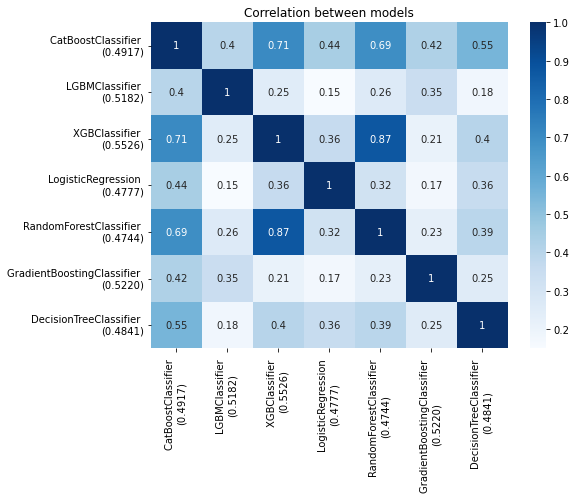

In [34]:
pred_results = []
for name, clf, clf_score in clfs_tuned:
    pred = clf.predict_proba(X_dev)[:,1]
    name = f'{name} \n({clf_score:.4f})'
    pred_results.append(pd.Series(pred, name=name))
ensemble_results = pd.concat(pred_results, axis=1)

# 모형의 예측값 간의 상관관계를 보기 위해 hitmap을 도식한다.
plt.figure(figsize = (8,6))
g = sns.heatmap(ensemble_results.corr(), annot=True, cmap='Blues')
g.set_title("Correlation between models")
plt.show()

In [59]:
# Mean agreement
(ensemble_results.corr().sum()-1)/(ensemble_results.corr().shape[0]-1)

CatBoostClassifier \n(0.4997)            0.443330
LGBMClassifier \n(0.5357)                0.217130
XGBClassifier \n(0.5655)                 0.409204
KNeighborsClassifier \n(0.5226)          0.139736
MLPClassifier \n(0.5169)                 0.176744
LogisticRegression \n(0.4805)            0.186095
RandomForestClassifier \n(0.4939)        0.395576
GradientBoostingClassifier \n(0.5192)    0.223666
DecisionTreeClassifier \n(0.4914)        0.251553
dtype: float64

In [60]:
ensemble_results

,CatBoostClassifier \n(0.4997),LGBMClassifier \n(0.5357),XGBClassifier \n(0.5655),KNeighborsClassifier \n(0.5226),MLPClassifier \n(0.5169),LogisticRegression \n(0.4805),RandomForestClassifier \n(0.4939),GradientBoostingClassifier \n(0.5192),DecisionTreeClassifier \n(0.4914)
0,0.033613,0.002856,0.284455,0.000000,9.512904e-05,0.082683,0.256271,0.000761,0.042437
1,0.072937,0.000173,0.451790,0.323203,1.418937e-05,0.076205,0.577760,0.000712,0.066473
2,0.042766,0.063828,0.349478,0.000000,5.613693e-08,0.071413,0.335809,0.000049,0.057143
3,0.121324,0.651361,0.497262,0.428370,4.545006e-05,0.079224,0.437322,0.008445,0.213235
4,0.083721,0.109532,0.460240,0.000000,3.220525e-04,0.081164,0.493927,0.014546,0.039623
...,...,...,...,...,...,...,...,...,...
4224,0.031136,0.000062,0.356228,0.000000,1.477722e-08,0.059636,0.293472,0.000001,0.042437
4225,0.066829,0.123654,0.465169,0.000000,6.730239e-05,0.083561,0.445028,0.495747,0.121771
4226,0.051296,0.005304,0.333230,0.294592,1.353230e-01,0.080149,0.283601,0.026891,0.066473
4227,0.049777,0.000218,0.353626,0.000000,6.648479e-09,0.093201,0.152462,0.001728,0.066473


In [35]:
# Averaging 앙상블에 사용하지 않을 모델은 주석 처리하시오.
selected = [
    'KNeighborsClassifier', 
    'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier',
    'DecisionTreeClassifier',
    'XGBClassifier',
    'LGBMClassifier',
    'CatBoostClassifier',
]
models_for_ensemble = [clf for clf in clfs_tuned if clf[0] in selected]

In [36]:
# 아래 코드는 추후 estimator class("BlendingClassifier")로 만들 예정

max_score = 0
for p in tqdm([0, 1, 2.56]):  # p==1:산술평균, p=0:기하평균, 그 외:멱평균(주의:멱평균은 과적합 가능성이 높음)    
    for i in range(2, len(models_for_ensemble)+1):
        for models in combinations(models_for_ensemble, i):
            if p == 0:
                pred_mean = gmean([clf.predict_proba(X_dev)[:,1] for name, clf, _ in models], axis=0)
            else:
                preds = [clf.predict_proba(X_dev)[:,1] for name, clf, _ in models]
                pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
            score = roc_auc_score(y_dev, pred_mean)
            if max_score < score:
                best_avg_ensemble = (p, models, score)
                max_score = score

p, models, score = best_avg_ensemble
print('p={}\n{}\n{}'.format(p, '●'.join([clf_name for clf_name, _, _ in models]), score))

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:00<00:00, 20.30s/it]

p=0
CatBoostClassifier●LogisticRegression●RandomForestClassifier
0.6890299640834072


In [37]:
# 2-layer stacking

# Initialize 1st level estimators
# 사용하지 않을 모델은 주석 처리하세요.
selected = [
    #'KNeighborsClassifier', 
    #'MLPClassifier',
    'LogisticRegression', 
    'RandomForestClassifier', 
    'GradientBoostingClassifier',
    'DecisionTreeClassifier',
    'XGBClassifier',
    'LGBMClassifier',
    'CatBoostClassifier',  
]

estimators = [(name, clf) for name, clf, _ in clfs_tuned if name in selected]
stk_clf = StackingClassifier(
    estimators = estimators, final_estimator = ExtraTreesClassifier(), cv=3)

stk_clf.fit(X_train, y_train)
print(roc_auc_score(y_dev, stk_clf.predict_proba(X_dev)[:,1]))

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=70, min_child_samples=25 will be ignored. Current value: min_data_in_leaf=70
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] num_iterations is set=300, num_iteration=300 will be ignored. Current value: num_iterations=300
[20:17:17] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "subsamle" } are not used.

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_frac

In [38]:
pred_mean

array([0.17954115, 0.33454137, 0.25051419, ..., 0.20746589, 0.20777531,
       0.33367455])

In [83]:
stk_clf.predict_proba(test_x)[:,1]

array([0.05, 0.1 , 0.17, ..., 0.07, 0.07, 0.08])

In [88]:
# Apply the best averaging ensemble model to Unseen Data
t = pd.Timestamp.now()
if p == 0:
    pred_mean = gmean([clf.predict(test_x)[:,1] for name, clf, _ in models], axis=0)
else:
    preds = [clf.predict(test_x)[:,1] for name, clf, _ in models]
    pred_mean = (np.sum(np.array(preds)**p, axis=0) / len(models))**(1/p)
pd.DataFrame({'ID': test_id, 'Y_LABEL': pred_mean}).to_csv(f'submission_avg_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv',index=False)

# Apply the stacking model to Unseen Data
pd.DataFrame({'ID': test_id, 'Y_LABEL': stk_clf.predict(test_x)[:,1]}).to_csv(f'submission_stk_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv', index=False)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [91]:
pd.DataFrame({'ID': test_id, 'Y_LABEL': stk_clf.predict_proba(test_x)[:,1]})['Y_LABEL'].apply(lambda x : 1 if x > 0.5 else 0).to_csv(f'submission_stk_{t.month:02}{t.day:02}_{t.hour:02}{t.minute:02}.csv', index=False)